# Amazon Food Reviews

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.


#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

## Excerpt 
1. Applied K-Nearest Neighbour on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Used both brute & kd-tree implementation of KNN <br>
3. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>

#### Import corresponding libraries into the working environment

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scikitplot
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
warnings.filterwarnings('ignore')
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Load Amazon Fine Food Review  into a dataframe

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e.  not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa

filtered_data['Score'] = filtered_data['Score'].map(partition) 

In [3]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Summary Statistics

In [4]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null object
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(4), object(6)
memory usage: 40.1+ MB


In [5]:
filtered_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,1.295943e+09
std,163984.038077,7.575819,8.195329,4.828129e+07
min,1.000000,0.000000,0.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,1.351210e+09


#### Statictics for categorical values

In [6]:
filtered_data.describe(include= ['O'])

,ProductId,UserId,ProfileName,Score,Summary,Text
count,525814,525814,525814,525814,525814,525814
unique,72005,243414,208273,2,271924,363836
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",positive,Delicious!,"This review will make me sound really stupid, ..."
freq,857,425,428,443777,2460,199


In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

#### Data Cleaning 

In [9]:
#original Dataset shape
filtered_data.shape

(525814, 10)

#### Training data Shape after eliminating duplicates

In [8]:

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

#### Function for Stemming the text and eliminating stop words

In [10]:
ps =  nltk.stem.SnowballStemmer('english')
def stem_sentences(sentence):
    tokens = nltk.word_tokenize(sentence)
    #print(tokens)
    stemmed_tokens = [] 
    for token in tokens:
        if token not in ((stopwords.words('english')) or (string.punctuation) or (string.printable)):
            a = re.sub(r'[.|,|)|(|\|/]',r'',ps.stem(token))
            a = re.sub('<.*?>', '', a)
            a = re.sub(r'[?|!|\'|"|#]',r'',a)
            stemmed_tokens.append(a)
    return ' '.join(stemmed_tokens)

In [11]:
final.Text.head(1)

138706    this witty little book makes my son laugh at l...
Name: Text, dtype: object

In [12]:
stem_sentences('this witty little book makes my son laugh at l...')

'witti littl book make son laugh l '

In [109]:
#final['Cleaned_Text'] = final['Text'].apply(stem_sentences)

#### Function to remove special characters

In [13]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'itself', 'again', 'out', 'herself', 'from', 'mustn', 'having', 'i', 'himself', 'has', "should've", "it's", 'our', 'mightn', 'other', 'she', 'been', "aren't", 'll', 'be', 'did', 'wasn', 'at', 'about', 'am', 'hers', 're', 'once', 'my', 'y', 'me', 'below', "you're", 'before', 'so', 'during', 'more', "she's", 'just', 'ma', 'both', 'shouldn', 'yourself', 't', 'they', 'under', 'm', 'through', 'ain', 'doing', 'needn', "won't", 'how', 'weren', 'there', 'over', 'd', 'between', 'his', 'it', 'off', 'can', 'her', 'same', 've', 'too', 'myself', 'on', 'while', 'is', 'such', 'aren', 'wouldn', 'are', 'only', 'should', "shan't", 'or', 'for', 'because', 'o', 'not', "hasn't", 'any', "don't", 'were', 'but', "weren't", "wouldn't", 'nor', 'those', "you'll", 'haven', 'that', 'and', "haven't", 'ours', 'had', "isn't", "didn't", 'who', 'most', 'than', 'now', 'your', 'where', 'being', 'ourselves', 'in', 'don', 'further', 'have', "needn't", 'own', 'to', 's', 'their', 'down', 'will', 'didn', 'he', 'very', 'then'

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [15]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

#### decode the cleaned text using uTF-8 format

In [16]:
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [17]:
final.to_pickle('final')

In [2]:
df_final = pd.read_pickle('final')

In [3]:
df_final.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...


In [4]:
final = df_final.copy()
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


#### Assigning numeric values to polarity

In [5]:
def polarity(x):
    if x == "positive":
        return 0
    else:
        return 1
df = final.copy()
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,0,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,0,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,0,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,0,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [6]:
#Desscribe Summary statistics
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,364173.000000,364173.000000,364173.000000,364173.000000,3.641730e+05
mean,282792.870949,1.739160,2.187125,0.156821,1.296135e+09
std,164592.179122,6.724567,7.349687,0.363632,4.864793e+07
min,1.000000,0.000000,0.000000,0.000000,9.393408e+08
25%,140714.000000,0.000000,0.000000,0.000000,1.270858e+09
50%,278979.000000,0.000000,1.000000,0.000000,1.311379e+09
75%,428539.000000,2.000000,2.000000,0.000000,1.332893e+09
max,568454.000000,866.000000,878.000000,1.000000,1.351210e+09


#### Describe Summary Statistics for Categorical Values

In [7]:
df.describe(include=['O'])

,ProductId,UserId,ProfileName,Summary,Text,CleanedText
count,364173,364173,364173,364173,364173,364173
unique,65442,243414,208273,271062,363836,363251
top,B007JFMH8M,AY12DBB0U420B,Gary Peterson,Delicious!,"Several years ago, I went on a tour of the Cel...",sever year ago went tour celesti season tea fa...
freq,856,310,310,1766,9,13


#### Visualizing the number of positive and negative scores in the preprocessed dataset

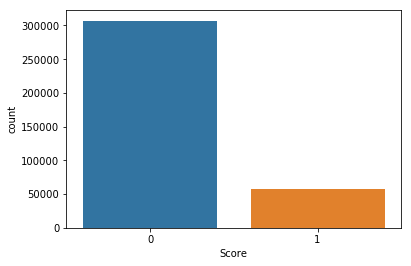

In [8]:
import seaborn as sns
sns.countplot(x='Score',data=df)

Taking 25000 samples from the total data set for processing as the sample dataset is very large

In [8]:
#Taking Sample Data
n_samples = 25000
df_sample = df.sample(n_samples)

###Sorting data as we want according to ascending order of time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,0,982800000,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,dont know anyon would ever use littl liquid fo...
346033,374335,B00004CI84,A3L5V40F14R2GP,AARON,0,0,0,1004054400,Beetlejuice! Beetlejuice! Beatlejuice!,Winona Ryder is HOT! HOT! HOT! as the gothic d...,winona ryder hot hot hot gothic princess doom ...
137935,149703,B00006L2ZT,A2Y8DAMQ4PHSK9,AWKword,2,6,0,1036713600,Never A Dull Moment,"Finally, a collection of the best Camper Van B...",final collect best camper van beethoven album ...


In [9]:
#Saving 25000 samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_25000_knn")

In [2]:
#Opening from samples from file
df_sample = openfromfile("sample_25000_knn")

In [3]:
df_sample.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,0,982800000,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,dont know anyon would ever use littl liquid fo...
346033,374335,B00004CI84,A3L5V40F14R2GP,AARON,0,0,0,1004054400,Beetlejuice! Beetlejuice! Beatlejuice!,Winona Ryder is HOT! HOT! HOT! as the gothic d...,winona ryder hot hot hot gothic princess doom ...
137935,149703,B00006L2ZT,A2Y8DAMQ4PHSK9,AWKword,2,6,0,1036713600,Never A Dull Moment,"Finally, a collection of the best Camper Van B...",final collect best camper van beethoven album ...


# Applying KNN to different text vectorizations using NLP

#### BOW(Bag of Words):
A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.

#### UNIGRAM

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 16989)
Test Data Size:  (7500, 16989)


In [13]:

Features = df_sample['CleanedText'].values
Labels = df_sample['Score'].values

#Normalize Feature data into a range between 0 and 1
Features = uni_gram.fit_transform(Features)
Feat_norm =  preprocessing.normalize(Features)
print(Feat_norm.shape)

(25000, 20039)


# Time Series cross-validator

Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate.

This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

In [14]:
#Using the 10 split time intervals cross validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(Feat_norm):
    X_train,X_test = Feat_norm[train],Feat_norm[cv]
    y_train,y_test = Labels[train],Labels[cv]
    print(X_train.shape, X_test.shape)
    print(y_train.shape, y_test.shape)

(2280, 20039) (2272, 20039)
(2280,) (2272,)
(4552, 20039) (2272, 20039)
(4552,) (2272,)
(6824, 20039) (2272, 20039)
(6824,) (2272,)
(9096, 20039) (2272, 20039)
(9096,) (2272,)
(11368, 20039) (2272, 20039)
(11368,) (2272,)
(13640, 20039) (2272, 20039)
(13640,) (2272,)
(15912, 20039) (2272, 20039)
(15912,) (2272,)
(18184, 20039) (2272, 20039)
(18184,) (2272,)
(20456, 20039) (2272, 20039)
(20456,) (2272,)
(22728, 20039) (2272, 20039)
(22728,) (2272,)


In [15]:
print('Shape of training data after the 10th Timeseries Split :\n')
print(X_train.shape,y_train.shape)
print('Shape of test data after the 10th Timeseries Split :\n')
print(X_test.shape,y_test.shape)


Shape of training data after the 10th Timeseries Split :

(22728, 20039) (22728,)
Shape of test data after the 10th Timeseries Split :

(2272, 20039) (2272,)


# Finding the best 'k' value using Forward Chaining Cross Validation

#### Using Brute force K Nearest Neigbour Algorithm to obtaing Optimal K value

In [16]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 80.89060987415296
Accuracy score for k 3 is 84.0513068731849
Accuracy score for k 5 is 84.81606969990318
Accuracy score for k 7 is 84.99031945788964
Accuracy score for k 9 is 85.01936108422072
Accuracy score for k 11 is 84.97095837366894
Accuracy score for k 13 is 84.97579864472411
Accuracy score for k 15 is 84.9031945788964
Accuracy score for k 17 is 84.77250726040658
Accuracy score for k 19 is 84.82090997095837
Accuracy score for k 21 is 84.76282671829622
Accuracy score for k 23 is 84.66118102613746
Accuracy score for k 25 is 84.63213939980639
Accuracy score for k 27 is 84.60793804453048
Accuracy score for k 29 is 84.60309777347531
Accuracy score for k 31 is 84.59825750242013
Accuracy score for k 33 is 84.55469506292351
Accuracy score for k 35 is 84.54501452081317
Accuracy score for k 37 is 84.51597289448209
Accuracy score for k 39 is 84.52565343659245
Accuracy score for k 41 is 84.47241045498546
Accuracy score for k 43 is 84.42400774443368
Accuracy score fo

In [17]:
savetofile(k_acc,"k_acc_uni_gram")

In [18]:
k_acc_uni_gram = openfromfile("k_acc_uni_gram")
k_acc_uni_gram

array([ 80.89060987,  84.05130687,  84.8160697 ,  84.99031946,
        85.01936108,  84.97095837,  84.97579864,  84.90319458,
        84.77250726,  84.82090997,  84.76282672,  84.66118103,
        84.6321394 ,  84.60793804,  84.60309777,  84.5982575 ,
        84.55469506,  84.54501452,  84.51597289,  84.52565344,
        84.47241045,  84.42400774,  84.40948693,  84.40464666,  84.39980639])

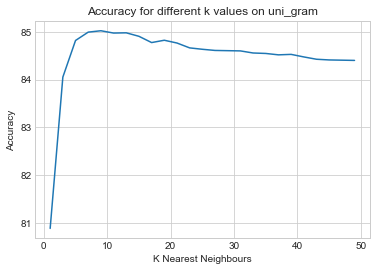

In [19]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on uni_gram")
plt.show()

In [20]:
k_score = k_acc.tolist()
print('Optimum K Value using Brute Force Algorithm : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))

Optimum K Value using Brute Force Algorithm :  9 with accuracy of : 85.01936108422072


# Grid Search CV

The above code for finding best value of 'k' can be condensed using Grid Search CV it tries all the possible params which tell it to try on and returns the best params and best accuracy 


In [ ]:
%time
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier(algorithm='brute')
# range of nearest neighbors= np.arange(1,40,2)
param_grid = {'n_neighbors':np.arange(1,10,2)} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(knn,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Wall time: 0 ns
Fitting 10 folds for each of 20 candidates, totalling 200 fits


UNABLE TO EXECUTE THE CODE My COMPUTER CRASHES EVERYTIME I EXECUTE THE ABOVE CODE

In [4]:
model_result = {}

In [5]:
Name =[]
Accuracy =[]
Optimum_k = []
Precision = []
Recall = []
F1_score = []


Accuracy is  84.375 %

Error  is  15.625 %

Precison score -KNN-brute force  - Unigram :  71.2643678161 %

Recall score  -KNN - brute force - Unigram :  15.8163265306 %

F1 Score -KNN - brute force - Unigram :  25.8872651357 %

Classification Report 
             precision    recall  f1-score   support

          0       0.85      0.99      0.91      1880
          1       0.71      0.16      0.26       392

avg / total       0.83      0.84      0.80      2272



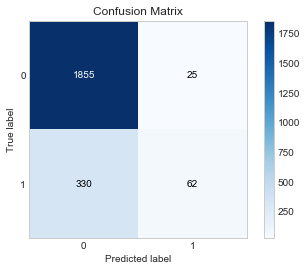

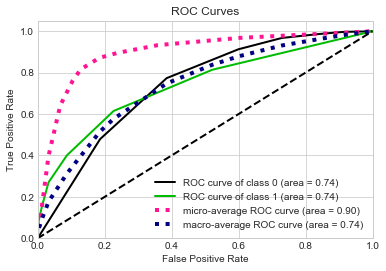

In [23]:
neigh = KNeighborsClassifier(n_neighbors = 9,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-brute force  - Unigram : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - brute force - Unigram : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - brute force - Unigram : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)

Name.append('Brute-Force-Unigram')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(9)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

#### K Nearest Neigbour using Kd-tree Algorithm to obtain Optimal K value

In [54]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 81.51572327044025
Accuracy score for k 3 is 84.64150943396227
Accuracy score for k 5 is 85.26415094339623
Accuracy score for k 7 is 85.48427672955975
Accuracy score for k 9 is 85.56603773584905
Accuracy score for k 11 is 85.49685534591195
Accuracy score for k 13 is 85.42767295597484
Accuracy score for k 15 is 85.31446540880503
Accuracy score for k 17 is 85.31446540880503
Accuracy score for k 19 is 85.27672955974843
Accuracy score for k 21 is 85.20125786163524
Accuracy score for k 23 is 85.22012578616354
Accuracy score for k 25 is 85.23270440251574
Accuracy score for k 27 is 85.23270440251574
Accuracy score for k 29 is 85.16352201257861
Accuracy score for k 31 is 85.10691823899371
Accuracy score for k 33 is 85.12578616352201
Accuracy score for k 35 is 85.11320754716982
Accuracy score for k 37 is 85.12578616352201
Accuracy score for k 39 is 85.08176100628931
Accuracy score for k 41 is 85.06918238993713
Accuracy score for k 43 is 85.04402515723271
Accuracy score 

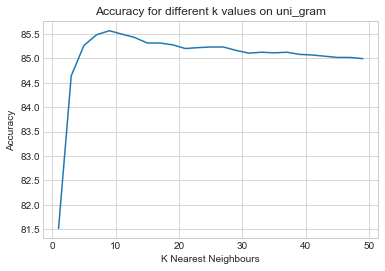

In [57]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on uni_gram")
plt.show()

In [59]:
k_score = k_acc.tolist()
print('Optimum K Value using kd-tree Algorithm : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))

Optimum K Value using kd-tree Algorithm :  9 with accuracy of : 85.56603773584905


C:\ProgramData\Anaconda3\envs\tfdeeplearning\lib\site-packages\sklearn\neighbors\base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "



Accuracy is  84.375 %

Error  is  15.625 %

Precison score -KNN-kd-tree  - Unigram :  71.2643678161 %

Recall score  -KNN - kd-tree -Unigram :  25.8872651357 %

Classification Report 
             precision    recall  f1-score   support

          0       0.85      0.99      0.91      1880
          1       0.71      0.16      0.26       392

avg / total       0.83      0.84      0.80      2272



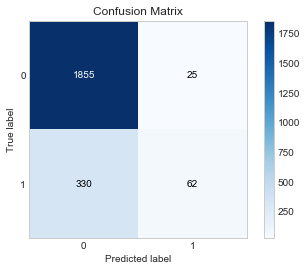

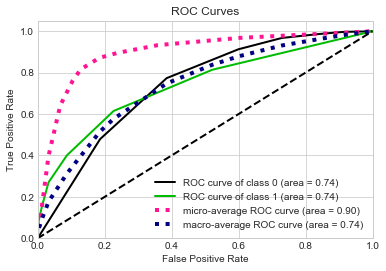

In [24]:
neigh = KNeighborsClassifier(n_neighbors = 9,algorithm='kd_tree')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-kd-tree  - Unigram : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - kd-tree -Unigram : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('kd-tree-Unigram')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(9)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

#### BI-GRAM

In [25]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 363368)
Test Data Size:  (7500, 363368)


#### K Nearest Neigbor Using Brute Force algorthim to find optimal value of K -bi-gram

In [26]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 81.01257861635222
Accuracy score for k 3 is 84.87421383647799
Accuracy score for k 5 is 85.75471698113208
Accuracy score for k 7 is 85.77987421383648
Accuracy score for k 9 is 85.8050314465409
Accuracy score for k 11 is 85.8176100628931
Accuracy score for k 13 is 85.62893081761005
Accuracy score for k 15 is 85.57232704402517
Accuracy score for k 17 is 85.50943396226417
Accuracy score for k 19 is 85.46540880503144
Accuracy score for k 21 is 85.42767295597486
Accuracy score for k 23 is 85.34591194968553
Accuracy score for k 25 is 85.33962264150944
Accuracy score for k 27 is 85.30188679245283
Accuracy score for k 29 is 85.32704402515724
Accuracy score for k 31 is 85.28301886792454
Accuracy score for k 33 is 85.22641509433963
Accuracy score for k 35 is 85.22641509433961
Accuracy score for k 37 is 85.16981132075473
Accuracy score for k 39 is 85.16352201257862
Accuracy score for k 41 is 85.15723270440253
Accuracy score for k 43 is 85.13207547169812
Accuracy score fo

In [27]:
savetofile(k_acc,"k_acc_bi_gram")

In [28]:
k_acc_bi_gram = openfromfile("k_acc_bi_gram")
k_acc_bi_gram

array([ 81.01257862,  84.87421384,  85.75471698,  85.77987421,
        85.80503145,  85.81761006,  85.62893082,  85.57232704,
        85.50943396,  85.46540881,  85.42767296,  85.34591195,
        85.33962264,  85.30188679,  85.32704403,  85.28301887,
        85.22641509,  85.22641509,  85.16981132,  85.16352201,
        85.1572327 ,  85.13207547,  85.10691824,  85.10062893,  85.06918239])

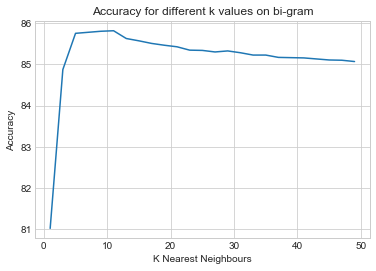

Optimum K Value using Brute Force Algorithm- for bi-gram  is :  11 with accuracy of : 85.8176100628931


In [33]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc_bi_gram)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi-gram")
plt.show()
k_score = k_acc_bi_gram.tolist()
print('Optimum K Value using Brute Force Algorithm- for bi-gram  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.96 %

Error  is  16.04 %

Precison score -KNN-brute force  - bi-gram :  73.3067729084 %

Recall score  -KNN - brute force - bi-gram :  13.9393939394 %

F1 Score -KNN - brute force - bi-gram :  23.4245703374 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.73      0.14      0.23      1320

avg / total       0.82      0.84      0.79      7500



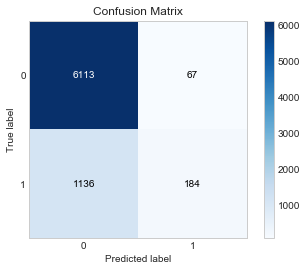

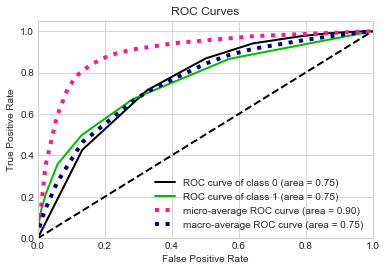

In [30]:
neigh = KNeighborsClassifier(n_neighbors = 11,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-brute force  - bi-gram : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - brute force - bi-gram : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - brute force - bi-gram : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('Brute-Force-bi-gram')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(11)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

#### K Nearest Neigbor Using kd_tree algorthim to find optimal value of K -bi-gram

In [37]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)

Accuracy score for k 1 is 81.01257861635222
Accuracy score for k 3 is 84.87421383647799
Accuracy score for k 5 is 85.75471698113208
Accuracy score for k 7 is 85.77987421383648
Accuracy score for k 9 is 85.8050314465409
Accuracy score for k 11 is 85.8176100628931
Accuracy score for k 13 is 85.62893081761005
Accuracy score for k 15 is 85.57232704402517
Accuracy score for k 17 is 85.50943396226417
Accuracy score for k 19 is 85.46540880503144
Accuracy score for k 21 is 85.42767295597486
Accuracy score for k 23 is 85.34591194968553
Accuracy score for k 25 is 85.33962264150944
Accuracy score for k 27 is 85.30188679245283
Accuracy score for k 29 is 85.32704402515724
Accuracy score for k 31 is 85.28301886792454
Accuracy score for k 33 is 85.22641509433963
Accuracy score for k 35 is 85.22641509433961
Accuracy score for k 37 is 85.16981132075473
Accuracy score for k 39 is 85.16352201257862
Accuracy score for k 41 is 85.15723270440253
Accuracy score for k 43 is 85.13207547169812
Accuracy score fo

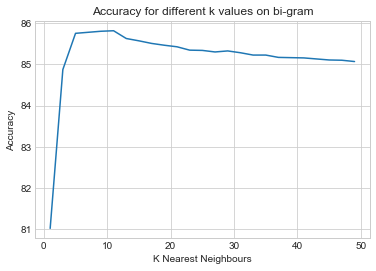

Optimum K Value using kd-tree Algorithm- for bi-gram  is :  11 with accuracy of : 85.8176100628931


In [39]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi-gram")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using kd-tree Algorithm- for bi-gram  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.96 %

Error  is  16.04 %

Precison score -KNN-kd-tree - bi-gram :  73.3067729084 %

Recall score  -KNN-kd-tree - bi-gram :  13.9393939394 %

F1 Score -KNN-kd-tree - bi-gram :  23.4245703374 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.73      0.14      0.23      1320

avg / total       0.82      0.84      0.79      7500



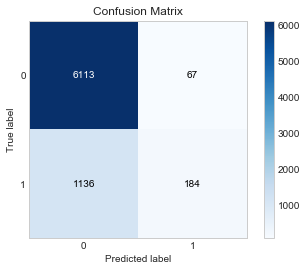

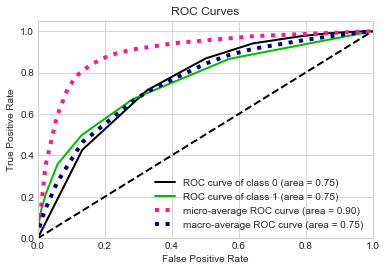

In [41]:
neigh = KNeighborsClassifier(n_neighbors = 11,algorithm='kd_tree')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-kd-tree - bi-gram : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN-kd-tree - bi-gram : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN-kd-tree - bi-gram : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('kd-tree-bi-gram')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(11)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

#### TERM FREQUENCY INVERSE DOCUMENT FREQUENCY(tf-idf)

* term frequency = tf(i,j) = number of occurrences of i in j
* document frequency = df(i) =  number of documents conatining i

In [43]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (17500, 363368)
Test Data Size:  (7500, 363368)
Wall time: 4.99 s


#### K Nearest Neigbor Using Brute Force algorthim to find optimal value of K tfidf(bi-gram)

In [44]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 81.22641509433961
Accuracy score for k 3 is 84.8930817610063
Accuracy score for k 5 is 85.67295597484278
Accuracy score for k 7 is 85.85534591194968
Accuracy score for k 9 is 85.8427672955975
Accuracy score for k 11 is 85.74842767295597
Accuracy score for k 13 is 85.63522012578616
Accuracy score for k 15 is 85.57861635220125
Accuracy score for k 17 is 85.45911949685534
Accuracy score for k 19 is 85.40251572327045
Accuracy score for k 21 is 85.35220125786165
Accuracy score for k 23 is 85.33962264150944
Accuracy score for k 25 is 85.30817610062893
Accuracy score for k 27 is 85.28930817610063
Accuracy score for k 29 is 85.24528301886792
Accuracy score for k 31 is 85.22012578616352
Accuracy score for k 33 is 85.16352201257862
Accuracy score for k 35 is 85.16352201257862
Accuracy score for k 37 is 85.14465408805032
Accuracy score for k 39 is 85.13207547169812
Accuracy score for k 41 is 85.1006289308176
Accuracy score for k 43 is 85.1069182389937
Accuracy score for 

In [45]:
savetofile(k_acc,"k_acc_tfidf")
k_acc_tfidf = openfromfile("k_acc_tfidf")
k_acc_tfidf

array([ 81.22641509,  84.89308176,  85.67295597,  85.85534591,
        85.8427673 ,  85.74842767,  85.63522013,  85.57861635,
        85.4591195 ,  85.40251572,  85.35220126,  85.33962264,
        85.3081761 ,  85.28930818,  85.24528302,  85.22012579,
        85.16352201,  85.16352201,  85.14465409,  85.13207547,
        85.10062893,  85.10691824,  85.09433962,  85.06918239,  85.05660377])

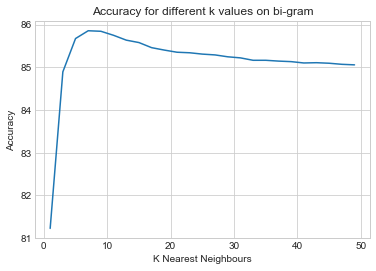

Optimum K Value using Brute Force Algorithm- for tf-idf(bi-gram)  is :  7 with accuracy of : 85.85534591194968


In [46]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi-gram")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using Brute Force Algorithm- for tf-idf(bi-gram)  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  84.2133333333 %

Error  is  15.7866666667 %

Precison score -KNN-brute force  - tfidf :  76.9841269841 %

Recall score  -KNN - brute force - tfidf :  14.696969697 %

F1 Score -KNN - brute force - tfidf :  24.6819338422 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.77      0.15      0.25      1320

avg / total       0.83      0.84      0.79      7500



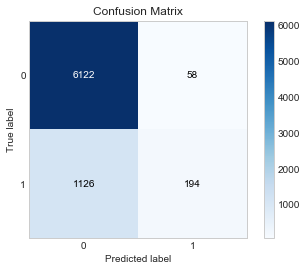

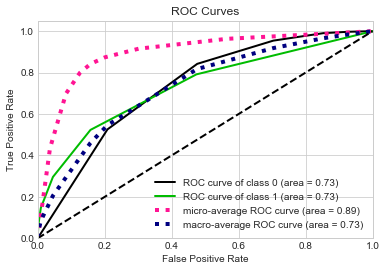

In [48]:
neigh = KNeighborsClassifier(n_neighbors = 7,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-brute force  - tfidf : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - brute force - tfidf : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - brute force - tfidf : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('Brute-Force-tfidf')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(7)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

In [49]:
Name

['Brute-Force-Unigram',
 'kd-tree-Unigram',
 'Brute-Force-bi-gram',
 'kd-tree-bi-gram',
 'Brute-Force-tfidf']

#### K Nearest Neigbor Using kd_tree algorthim to find optimal value of K for tf-idf(bi-gram)

In [50]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)

Accuracy score for k 1 is 81.22641509433961
Accuracy score for k 3 is 84.8930817610063
Accuracy score for k 5 is 85.67295597484278
Accuracy score for k 7 is 85.85534591194968
Accuracy score for k 9 is 85.8427672955975
Accuracy score for k 11 is 85.74842767295597
Accuracy score for k 13 is 85.63522012578616
Accuracy score for k 15 is 85.57861635220125
Accuracy score for k 17 is 85.45911949685534
Accuracy score for k 19 is 85.40251572327045
Accuracy score for k 21 is 85.35220125786165
Accuracy score for k 23 is 85.33962264150944
Accuracy score for k 25 is 85.30817610062893
Accuracy score for k 27 is 85.28930817610063
Accuracy score for k 29 is 85.24528301886792
Accuracy score for k 31 is 85.22012578616352
Accuracy score for k 33 is 85.16352201257862
Accuracy score for k 35 is 85.16352201257862
Accuracy score for k 37 is 85.14465408805032
Accuracy score for k 39 is 85.13207547169812
Accuracy score for k 41 is 85.1006289308176
Accuracy score for k 43 is 85.1069182389937
Accuracy score for 

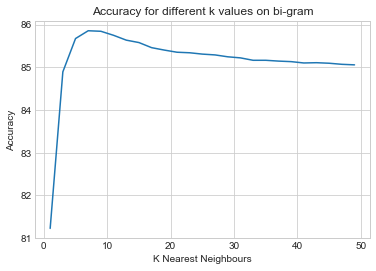

Optimum K Value using kd tree Algorithm- for tf-idf(bi-gram)  is :  7 with accuracy of : 85.85534591194968


In [51]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi-gram")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using kd tree Algorithm- for tf-idf(bi-gram)  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  84.2133333333 %

Error  is  15.7866666667 %

Precison score -KNN-kd-tree  - tfidf :  76.9841269841 %

Recall score  -KNN - kd-tree - tfidf :  14.696969697 %

F1 Score -KNN - kd-tree - tfidf :  24.6819338422 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.77      0.15      0.25      1320

avg / total       0.83      0.84      0.79      7500



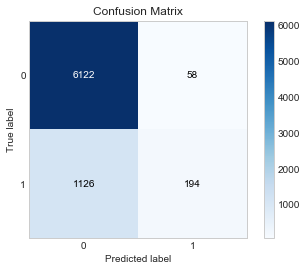

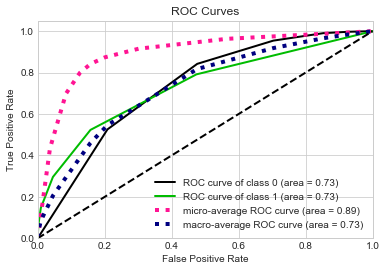

In [53]:
neigh = KNeighborsClassifier(n_neighbors = 7,algorithm='kd_tree')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-kd-tree  - tfidf : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - kd-tree - tfidf : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - kd-tree - tfidf : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('kd-tree-tfidf')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(7)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

In [54]:
Name

['Brute-Force-Unigram',
 'kd-tree-Unigram',
 'Brute-Force-bi-gram',
 'kd-tree-bi-gram',
 'Brute-Force-tfidf',
 'kd-tree-tfidf']

# Gensim

Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

# Word2Vec

In [6]:
from gensim.models import KeyedVectors

In [7]:
%%time
#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 
#w2vec_model = Word2Vec()

Wall time: 11min 42s


In [8]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

# Avg Word2Vec

•One of the most naive but good ways to convert a sentence into a vector

•Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 


In [9]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    #sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

Wall time: 13.7 s


In [10]:
avg_vec_google.shape

(25000, 300)

In [11]:
np.isnan(avg_vec_google).any()

False

In [12]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

In [13]:
print('Shape of X_train : {}, Shape of X_test : {} '.format(X_train.shape,X_test.shape))

Shape of X_train : (17500, 300), Shape of X_test : (7500, 300) 


#### K Nearest Neigbor Using Brute Force algorthim to find optimal value of K for Word2Vec

In [69]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 80.96226415094341
Accuracy score for k 3 is 84.43396226415095
Accuracy score for k 5 is 85.062893081761
Accuracy score for k 7 is 85.25157232704403
Accuracy score for k 9 is 85.18238993710692
Accuracy score for k 11 is 85.25157232704402
Accuracy score for k 13 is 85.20125786163521
Accuracy score for k 15 is 85.20125786163524
Accuracy score for k 17 is 85.15723270440253
Accuracy score for k 19 is 85.1698113207547
Accuracy score for k 21 is 85.11949685534591
Accuracy score for k 23 is 85.1069182389937
Accuracy score for k 25 is 85.06289308176102
Accuracy score for k 27 is 85.0
Accuracy score for k 29 is 85.00000000000001
Accuracy score for k 31 is 84.98113207547172
Accuracy score for k 33 is 84.96855345911949
Accuracy score for k 35 is 84.96855345911949
Accuracy score for k 37 is 84.9433962264151
Accuracy score for k 39 is 84.9496855345912
Accuracy score for k 41 is 84.9559748427673
Accuracy score for k 43 is 84.9245283018868
Accuracy score for k 45 is 84.930817

In [70]:
savetofile(k_acc,"k_acc_avg_w2v")
k_acc_avg_w2vec = openfromfile("k_acc_avg_w2v")
k_acc_avg_w2vec

array([ 80.96226415,  84.43396226,  85.06289308,  85.25157233,
        85.18238994,  85.25157233,  85.20125786,  85.20125786,
        85.1572327 ,  85.16981132,  85.11949686,  85.10691824,
        85.06289308,  85.        ,  85.        ,  84.98113208,
        84.96855346,  84.96855346,  84.94339623,  84.94968553,
        84.95597484,  84.9245283 ,  84.93081761,  84.91823899,  84.91823899])

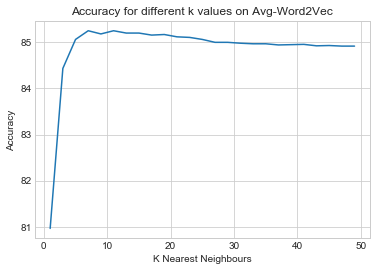

Optimum K Value using Brute Force Algorithm- for Word2Vec  is :  7 with accuracy of : 85.25157232704403


In [73]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on Avg-Word2Vec")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using Brute Force Algorithm- for Word2Vec  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.48 %

Error  is  16.52 %

Precison score -KNN-brute force  - Avg-Word2Vec :  66.1354581673 %

Recall score  -KNN - brute force - Avg-Word2Vec :  12.5757575758 %

F1 Score -KNN - brute force - Avg-Word2Vec :  21.1330362826 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.66      0.13      0.21      1320

avg / total       0.81      0.83      0.79      7500



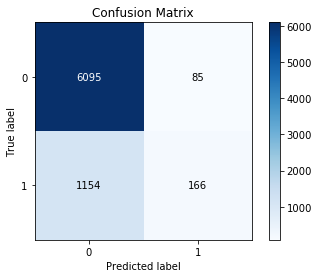

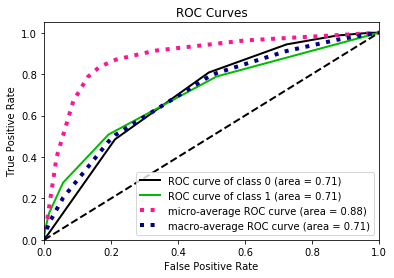

In [14]:
neigh = KNeighborsClassifier(n_neighbors = 7,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-brute force  - Avg-Word2Vec : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - brute force - Avg-Word2Vec : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - brute force - Avg-Word2Vec : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('Brute-Force-Avg-Word2Vec')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(7)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

##### K Nearest Neigbor Using kd-tree algorthim to find optimal value of K for Word2Vec

In [15]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 80.96226415094341
Accuracy score for k 3 is 84.43396226415095
Accuracy score for k 5 is 85.062893081761
Accuracy score for k 7 is 85.25157232704403
Accuracy score for k 9 is 85.18238993710692
Accuracy score for k 11 is 85.25157232704402
Accuracy score for k 13 is 85.20125786163521
Accuracy score for k 15 is 85.20125786163524
Accuracy score for k 17 is 85.15723270440253
Accuracy score for k 19 is 85.1698113207547
Accuracy score for k 21 is 85.11949685534591
Accuracy score for k 23 is 85.1069182389937
Accuracy score for k 25 is 85.06289308176102
Accuracy score for k 27 is 85.0
Accuracy score for k 29 is 85.00000000000001
Accuracy score for k 31 is 84.98113207547172
Accuracy score for k 33 is 84.96855345911949
Accuracy score for k 35 is 84.96855345911949
Accuracy score for k 37 is 84.9433962264151
Accuracy score for k 39 is 84.9496855345912
Accuracy score for k 41 is 84.9559748427673
Accuracy score for k 43 is 84.9245283018868
Accuracy score for k 45 is 84.930817

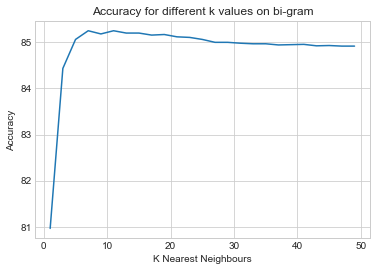

Optimum K Value using kd-tree Algorithm- for Word2Vec  is :  7 with accuracy of : 85.25157232704403


In [16]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on bi-gram")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using kd-tree Algorithm- for Word2Vec  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.48 %

Error  is  16.52 %

Precison score -KNN-kd-tree  - AvgWord2Vec :  66.1354581673 %

Recall score  -KNN - kd-tree - AvgWord2Vec :  12.5757575758 %

F1 Score -KNN - kd-tree - AvgWord2Vec :  21.1330362826 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.66      0.13      0.21      1320

avg / total       0.81      0.83      0.79      7500



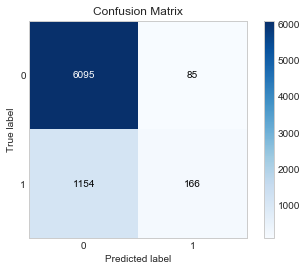

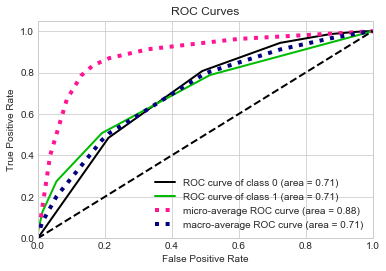

In [17]:
neigh = KNeighborsClassifier(n_neighbors = 7,algorithm='kd_tree')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-kd-tree  - AvgWord2Vec : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - kd-tree - AvgWord2Vec : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - kd-tree - AvgWord2Vec : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('kd-tree-AvgWord2Vec')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(7)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [9]:
%%time

###tf-idf 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams

tfidf_vec_new = tfidf.fit_transform(df_sample['CleanedText'].values)

print(tfidf_vec_new.shape)

features = tfidf.get_feature_names()

(25000, 476369)
Wall time: 16 s


In [10]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample['CleanedText'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    #sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
            #print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
            pass
    if weighted_sum != 0:
        sent_vec /= weighted_sum
        #print('tfidf-w2v-vec for review {}'.format(review))
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

Wall time: 6h 12min 20s


In [11]:
%%time
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidf_w2v_vec_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidf_w2v_vec_norm,df_sample['Score'].values,test_size=0.3,shuffle=False)

Wall time: 686 ms


In [12]:
print(X_train.shape)
print(X_test.shape)

(17500, 300)
(7500, 300)


#### K Nearest Neigbor Using Brute Force algorthim to find optimal value of K for tfidf_Word2Vec

In [13]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='brute')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 79.28930817610065
Accuracy score for k 3 is 83.72327044025158
Accuracy score for k 5 is 84.81132075471699
Accuracy score for k 7 is 85.0691823899371
Accuracy score for k 9 is 85.16352201257862
Accuracy score for k 11 is 85.20754716981132
Accuracy score for k 13 is 85.11320754716982
Accuracy score for k 15 is 85.1509433962264
Accuracy score for k 17 is 85.10691823899371
Accuracy score for k 19 is 85.0251572327044
Accuracy score for k 21 is 85.01886792452831
Accuracy score for k 23 is 85.0062893081761
Accuracy score for k 25 is 85.0125786163522
Accuracy score for k 27 is 85.0062893081761
Accuracy score for k 29 is 84.9748427672956
Accuracy score for k 31 is 84.9308176100629
Accuracy score for k 33 is 84.9433962264151
Accuracy score for k 35 is 84.9433962264151
Accuracy score for k 37 is 84.94968553459121
Accuracy score for k 39 is 84.95597484276729
Accuracy score for k 41 is 84.9433962264151
Accuracy score for k 43 is 84.9433962264151
Accuracy score for k 45 is 

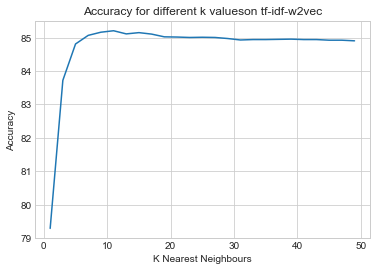

Optimum K Value using Brute-Force Algorithm- for tfidf_Word2Vec  is :  11 with accuracy of : 85.20754716981132


In [14]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k valueson tf-idf-w2vec")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using Brute-Force Algorithm- for tfidf_Word2Vec  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.2 %

Error  is  16.8 %

Precison score -KNN-brute force  - tfidf_Word2Vec :  65.9574468085 %

Recall score  -KNN - brute force - tfidf_ord2Vec :  9.39393939394 %

F1 Score -KNN - brute force - tfidf_Word2Vec :  16.4456233422 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.66      0.09      0.16      1320

avg / total       0.81      0.83      0.78      7500



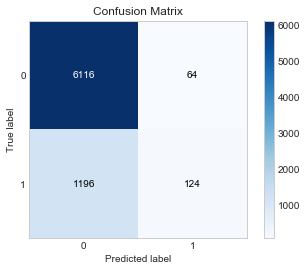

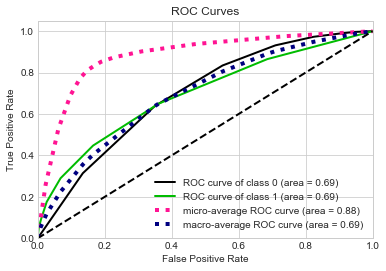

In [15]:
neigh = KNeighborsClassifier(n_neighbors = 11,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-brute force  - tfidf_Word2Vec : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - brute force - tfidf_ord2Vec : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - brute force - tfidf_Word2Vec : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('Brute-Force-tfidf_Word2Vec')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(11)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

#### K Nearest Neighbor Using kd-tree algorthim to find optimal value of K for tfidf_Word2Vec

In [16]:
%%time
#No of splits for Forward Chaining Cross Validation
n_splits = 10  
#Max no. of neighbours for KNN
neigh_max = 50

tscv = TimeSeriesSplit(n_splits=n_splits)
#To store accuracy of different k values
k_acc = []
k_val =[]
for k in range(1,neigh_max,2):
    #To store accuracy of different fold
    acc_list = []
    for train, cv in tscv.split(X_train):
          if(train.size > k): 
            knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
            knn.fit(X_train[train],y_train[train])
            acc_list.append(knn.score(X_train[cv],y_train[cv])*100)
            
            
    if(acc_list):        
        acc_nparr = np.array(acc_list)
    print('Accuracy score for k {} is {}'.format(k,acc_nparr.mean()))
    k_val.append(k)
    k_acc.append(acc_nparr.mean())
k_acc = np.array(k_acc)    

Accuracy score for k 1 is 79.28930817610065
Accuracy score for k 3 is 83.72327044025158
Accuracy score for k 5 is 84.81132075471699
Accuracy score for k 7 is 85.0691823899371
Accuracy score for k 9 is 85.16352201257862
Accuracy score for k 11 is 85.20754716981132
Accuracy score for k 13 is 85.11320754716982
Accuracy score for k 15 is 85.1509433962264
Accuracy score for k 17 is 85.10691823899371
Accuracy score for k 19 is 85.0251572327044
Accuracy score for k 21 is 85.01886792452831
Accuracy score for k 23 is 85.0062893081761
Accuracy score for k 25 is 85.0125786163522
Accuracy score for k 27 is 85.0062893081761
Accuracy score for k 29 is 84.9748427672956
Accuracy score for k 31 is 84.9308176100629
Accuracy score for k 33 is 84.9433962264151
Accuracy score for k 35 is 84.9433962264151
Accuracy score for k 37 is 84.94968553459121
Accuracy score for k 39 is 84.95597484276729
Accuracy score for k 41 is 84.9433962264151
Accuracy score for k 43 is 84.9433962264151
Accuracy score for k 45 is 

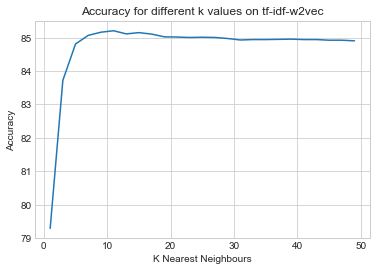

Optimum K Value using kd-tree Algorithm- for tfidf_Word2Vec  is :  11 with accuracy of : 85.20754716981132


In [17]:
sns.set_style("whitegrid")
plt.plot(k_val,k_acc)
plt.xlabel("K Nearest Neighbours")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values on tf-idf-w2vec")
plt.show()
k_score = k_acc.tolist()
print('Optimum K Value using kd-tree Algorithm- for tfidf_Word2Vec  is : ',k_val[k_score.index(max(k_score))],'with accuracy of :',max(k_score))


Accuracy is  83.2 %

Error  is  16.8 %

Precison score -KNN-kd-tree  - tfidf_Word2Vec :  65.9574468085 %

Recall score  -KNN - kd-tree - tfidf_Word2Vec :  9.39393939394 %

F1 Score -KNN - kd-tree - tf_idf_Word2Vec :  16.4456233422 %

Classification Report 
             precision    recall  f1-score   support

          0       0.84      0.99      0.91      6180
          1       0.66      0.09      0.16      1320

avg / total       0.81      0.83      0.78      7500



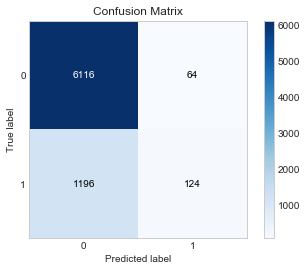

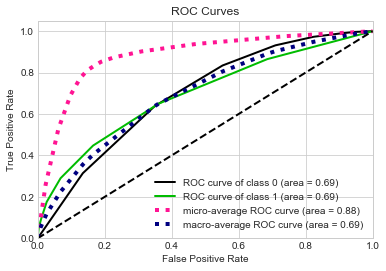

In [18]:
neigh = KNeighborsClassifier(n_neighbors = 11,algorithm='brute')
neigh.fit(X_train,y_train) 
y_pred = neigh.predict(X_test)
y_pred_proba = neigh.predict_proba(X_test)
print("\nAccuracy is ", metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nError  is ", 100 - metrics.accuracy_score(y_test,y_pred)*100,"%")
print("\nPrecison score -KNN-kd-tree  - tfidf_Word2Vec : ",metrics.precision_score(y_test,y_pred)*100,"%")
print("\nRecall score  -KNN - kd-tree - tfidf_Word2Vec : ",metrics.recall_score(y_test,y_pred)*100,"%")
print("\nF1 Score -KNN - kd-tree - tf_idf_Word2Vec : ",metrics.f1_score(y_test,y_pred)*100,"%")
print('\nClassification Report ')
print(metrics.classification_report(y_test,y_pred))
scikitplot.metrics.plot_confusion_matrix(y_test,y_pred)
scikitplot.metrics.plot_roc(y_test,y_pred_proba)
Name.append('kd-tree-tfi_df_Word2Vec')
Accuracy.append(metrics.accuracy_score(y_test,y_pred)*100)
Optimum_k.append(11)
Precision.append(metrics.precision_score(y_test,y_pred)*100)
Recall.append(metrics.recall_score(y_test,y_pred)*100)
F1_score.append(metrics.f1_score(y_test,y_pred)*100)

# CONCLUSION :

In [28]:
df_results

,Name,Optimum K,Accuracy,Precision,Recall,F1 Score,Data Sample
0,Brute-Force-Unigram,9,84.375000,71.264368,15.816327,25.887265,25000
1,kd-tree-Unigram,9,84.375000,71.264368,15.816327,25.887265,25000
2,Brute-Force-bi-gram,11,83.960000,73.306773,13.939394,23.424570,25000
3,kd-tree-bi-gram,11,83.960000,73.306773,13.939394,23.424570,25000
4,Brute-Force-tfidf,7,84.213333,76.984127,14.696970,24.681934,25000
5,kd-tree-tfidf,7,84.213333,76.984127,14.696970,24.681934,25000
6,Brute-Force-Avg-Word2Vec,7,83.480000,66.135458,12.575758,21.133036,25000
7,kd-tree-AvgWord2Vec,7,83.480000,66.135458,12.575758,21.133036,25000
8,Brute-Force-tfidf_Word2Vec,11,83.200000,65.957447,9.393939,16.445623,25000
9,kd-tree-tfi_df_Word2Vec,11,83.200000,65.957447,9.393939,16.445623,25000


#### Note: 
    
Have considered only 25k points(due to huge training time) the accuracy will not be the representive of the real accuracy

1.Best Accuracy of 84.375% is achieved by Unigram Featurization

2.The kd-tree and brute implementation of KNN gives relatively similar results

3.KNN is a very slow Algorithm compared to others takes alot of time to train

4.KNN did not fair in terms of precision and F1-score. Overall KNN was not that good for this dataset
